# Initiation

In [1]:
# To manipulate arrays
import numpy as np 
# To import images 

# To handle track DataFrames
import pandas as pd

# To import images
from skimage import io 
from skimage.io import imread

# For TrackPy
import trackpy as tp

# To make plots
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()  

# To work inline; change to %matplotlib notebook for interactive plotting
%matplotlib inline 

# Napari 
%gui qt5 
from skimage import data
import napari

# To create interactive elements
import ipywidgets as widgets 
from ipywidgets import interact, interactive, fixed, interact_manual, Button, HBox, VBox, Layout, GridspecLayout
from ipywidgets.embed import embed_minimal_html, dependency_state

# Image processing and filters
from skimage.filters import difference_of_gaussians

# Iteration tools such as groupby 
import itertools

# For directories 
import os
from pathlib import Path, PureWindowsPath # for working with windows paths

# For reloading a library when testing
import importlib

# For deleting/reloading modules in another file for code testing
import sys

# For working with x-arrays
import xarray as xr

# Import trackArrayTools
cwd = os.getcwd()
os.chdir("../src")
from track_array_tools import *
os.chdir(cwd)

# # Just in case you want to edit the track_array_tools.py code and test it, use the following
# cwd = os.getcwd()
# os.chdir("../src")
# del sys.modules['track_array_tools']  # Use this if you are coding new class methods and want to reread trackArrayTools.py file
# from track_array_tools import *
# os.chdir(cwd)

# Read in video and csv tracking file to generate crop array video

In [2]:
# Enter in the following:
crop_pad = 5    # specifies the size of crops in track arary. If 5, then crops are (2*5 + 1 = 11) x 11
xy_pixel_size = 130   # voxel  xy dimensions in crops
z_pixel_size = 500   # voxel z dimension
video_3D_directory = r'../database'
video_3D_filename = r'Hela_confocal.tif'
csv_filename = r'Tracks_Hela_confocal.csv'
#  crop array filenames should be the following:
crop_array_filename = 'Crops_' + video_3D_filename[:-4] + '_crop_pad_' + str(crop_pad) + '.tif' 
crop_filename = crop_array_filename[:-15] + '.csv'
# For display, so z and xy are shown properly when viewing crop array
z_renorm = z_pixel_size/xy_pixel_size  

In [6]:
# Read in the 3D video 
video_3D = imread(os.path.join(video_3D_directory,video_3D_filename))
video_3D.shape

(33, 7, 472, 312, 3)

In [7]:
# Read in the tracking file that corresponds to the original 3D video
# csv file can have many columns, but must have POSITION_X, POSITION_Y,
tracks = pd.read_csv(os.path.join(video_3D_directory, crop_filename)) 
tracks.head()

,Label,ID,TRACK_ID,QUALITY,POSITION_X,POSITION_Y,POSITION_Z,POSITION_T,FRAME,RADIUS,...,MANUAL_COLOR,MEAN_INTENSITY,MEDIAN_INTENSITY,MIN_INTENSITY,MAX_INTENSITY,TOTAL_INTENSITY,STANDARD_DEVIATION,ESTIMATED_DIAMETER,CONTRAST,SNR
0,ID10777,10777,0,458.712,69.0,14.0,0.0,0,0,3.5,...,-10921639,1097.358,1080,564,2118,374199,199.929,13.300,0.069,0.708
1,ID11306,11306,0,567.212,69.0,13.0,0.0,1,1,3.5,...,-10921639,1135.689,1119,722,2142,387270,200.616,11.816,0.086,0.896
2,ID11135,11135,0,552.813,69.0,14.0,0.0,2,2,3.5,...,-10921639,1129.935,1106,671,2660,385308,213.099,10.408,0.080,0.788
3,ID10954,10954,0,583.929,69.0,14.0,0.0,3,3,3.5,...,-10921639,1129.091,1115,627,2281,385020,222.905,12.483,0.083,0.773
4,ID11466,11466,0,504.716,70.0,13.0,0.0,4,4,3.5,...,-10921639,1120.109,1100,624,2455,381957,203.120,12.474,0.084,0.853


In [8]:
# Create crop array tif video from the original 3D video
# This only needs to be done once. Thereafter, can skip and just work with crop array itself
# Video dimensiosn MUST BE T, Z, Y, X, C or, if single channel video, then MUST BE T, Z, Y, X  
create_track_array_video(video_3D_directory, crop_array_filename, video_3D, tracks, crop_pad, xy_pixel_size, z_pixel_size)

c:\Users\tim_s\OneDrive - Colostate\Stasevich Lab\Lab Management\Dry Lab\Python\croparray\src\track_array_tools.py:864: UserWarning: ../database\Crops_Hela_confocal_crop_pad_5.tif is a low contrast image
  metadata={'spacing':z_pixel_size,'unit':'nm'})  # store z spaxing in nm and set units to nm


# Create an X-array dataset using the CropArray class

In [11]:
# Read in the crop array video and the tracks files:
crop_array_vid = imread(os.path.join(video_3D_directory, crop_array_filename))  # Read in crop array .tif file
crop_array_df = pd.read_csv(os.path.join(video_3D_directory, crop_filename)) # Read in tracks are read in as "dataframes (df)"

Once the crop array tif video is created, then we can create the TrackArray object, which will link the crop array tif video and the corresponding crop array file. Here I name the TrackArray object ca. This could be anything, but by convention we keep it simple. If you are working with more than one crop array object, you could call them ta1, ta2, ..., for example. Or it is possible to even make a list of crop array objects, etc.

In [12]:
# Create a crop array object:
ca = CropArray(crop_array_vid, crop_array_df, crop_pad)

In [13]:
# Create a best-z projection, bext_z, and also a best_z projection that is background corrected, best_z_bg
my_best_z_masks = ca.best_z_mask(1,0,z_offset = [0,0,0]) # best-z mask w/0 z-offset between channels
best_z = ca.mask_projection(np.clip(ca.arr,0,1000000), my_best_z_masks) # best-z projection; clip to make sure data is +
best_z_bg = ca.local_background_subtract(best_z,ca.donut_mask_2D(5,1)) # subtract background in donut rings from max projection  

In [14]:
# Create an X-array object from the crop array:
crop_number =np.arange(ca.n_crops())
frame =np.arange(ca.n_frames())
z=np.arange(ca.z_slices())
y=np.arange(-ca.crop_pad,ca.crop_pad+1)
x=np.arange(-ca.crop_pad,ca.crop_pad+1)
ch=np.arange(ca.n_channels())
int = xr.DataArray(ca.crops(), coords=[crop_number,frame,z,y,x,ch], dims=["crop_number","frame","z","y","x","ch"])
best_z_int = xr.DataArray(ca.array_to_crops(best_z),coords=[crop_number,frame,y,x,ch],dims=["crop_number","frame","y","x","ch"])
best_z_bg_int = xr.DataArray(ca.array_to_crops(best_z_bg),coords=[crop_number,frame,y,x,ch],dims=["crop_number","frame","y","x","ch"])

In [15]:
# Create an X-array dataset
my_ds = xr.Dataset({
'intensity':int,
'intensity_best_z':best_z_int,
'intensity_best_z_bg':best_z_bg_int
}, 
attrs = {'example attrs':'This is a global attribute'}
)

# Plotting examples

C:\Users\tim_s\Anaconda3\lib\site-packages\xarray\plot\plot.py:1344: FutureWarning: Conversion of the second argument of issubdtype from `str` to `str` is deprecated. In future, it will be treated as `np.str_ == np.dtype(str).type`.
  if np.issubdtype(x.dtype, str):
C:\Users\tim_s\Anaconda3\lib\site-packages\xarray\plot\plot.py:1395: FutureWarning: Conversion of the second argument of issubdtype from `str` to `str` is deprecated. In future, it will be treated as `np.str_ == np.dtype(str).type`.
  if np.issubdtype(v.dtype, str):


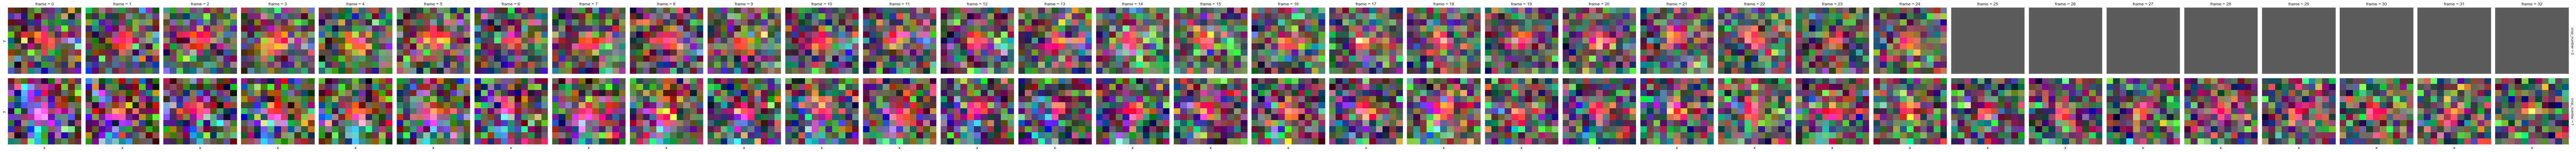

In [16]:
my_ds.intensity_best_z_bg.sel(frame=slice(0,33),crop_number=slice(0,1)).plot.imshow(col='frame',row='crop_number',rgb='ch',yticks=[],xticks=[],robust=True)

C:\Users\tim_s\Anaconda3\lib\site-packages\xarray\plot\plot.py:1344: FutureWarning: Conversion of the second argument of issubdtype from `str` to `str` is deprecated. In future, it will be treated as `np.str_ == np.dtype(str).type`.
  if np.issubdtype(x.dtype, str):
C:\Users\tim_s\Anaconda3\lib\site-packages\xarray\plot\plot.py:1395: FutureWarning: Conversion of the second argument of issubdtype from `str` to `str` is deprecated. In future, it will be treated as `np.str_ == np.dtype(str).type`.
  if np.issubdtype(v.dtype, str):


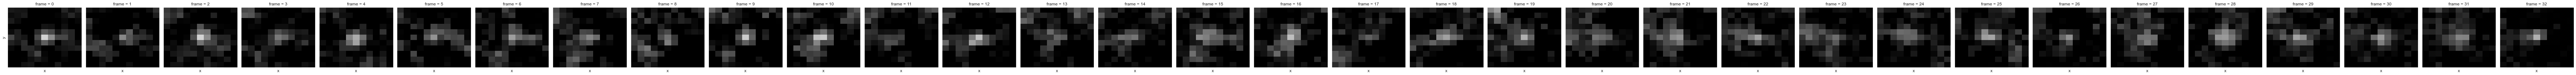

In [18]:
my_ds.intensity_best_z_bg.groupby('frame').mean('crop_number').sel(ch=1).plot.imshow(col='frame',yticks=[],xticks=[],cmap='gray',add_colorbar=False, vmin=0,vmax=10)

C:\Users\tim_s\Anaconda3\lib\site-packages\xarray\plot\plot.py:1344: FutureWarning: Conversion of the second argument of issubdtype from `str` to `str` is deprecated. In future, it will be treated as `np.str_ == np.dtype(str).type`.
  if np.issubdtype(x.dtype, str):
C:\Users\tim_s\Anaconda3\lib\site-packages\xarray\plot\plot.py:1395: FutureWarning: Conversion of the second argument of issubdtype from `str` to `str` is deprecated. In future, it will be treated as `np.str_ == np.dtype(str).type`.
  if np.issubdtype(v.dtype, str):


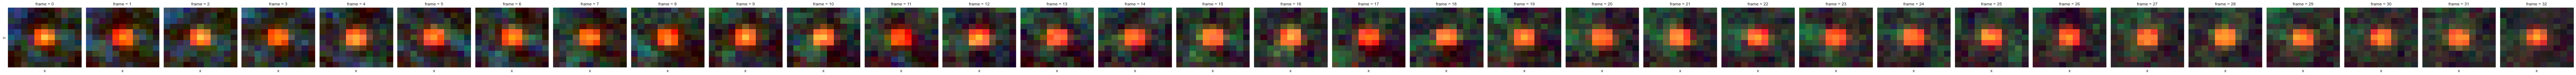

In [19]:
my_ds.intensity_best_z_bg.groupby('frame').mean('crop_number').plot.imshow(col='frame',rgb='ch',yticks=[],xticks=[],robust=True)

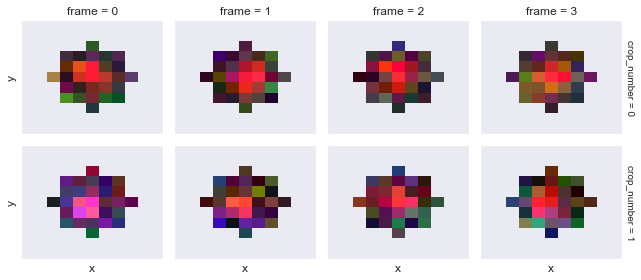

In [20]:
my_ds.intensity_best_z_bg.where(lambda x: x.x**2 + x.y**2 <= 3**2).sel(frame=slice(0,3),crop_number=slice(0,1)).plot.imshow(col='frame',row='crop_number',rgb='ch',yticks=[],xticks=[],robust=True,size=2)

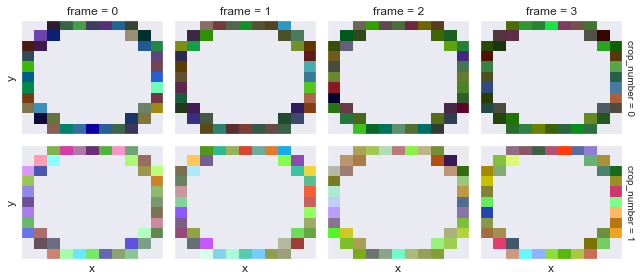

In [21]:
my_ds.intensity_best_z.where(lambda x: (x.x**2 + x.y**2 >= 5**2) & (x.x**2 + x.y**2 < 6**2)).sel(frame=slice(0,3),crop_number=slice(0,1)).plot.imshow(col='frame',row='crop_number',rgb='ch',yticks=[],xticks=[],robust=True,size=2)

## Disk-donut quantification

In [24]:
disk = my_ds.intensity_best_z.where(lambda x: x.x**2 + x.y**2 <= 3**2).mean(dim=['x','y'])
donut = my_ds.intensity_best_z.where(lambda x: (x.x**2 + x.y**2 >= 5**2) & (x.x**2 + x.y**2 < 6**2)).mean(dim=['x','y'])
my_signal = disk - donut
my_signal_norm = ( my_signal-my_signal.sel(frame=slice(30,33)).mean('frame') )/( my_signal.sel(frame=slice(0,4)).mean('frame')-my_signal.sel(frame=slice(30,33)).mean('frame') )

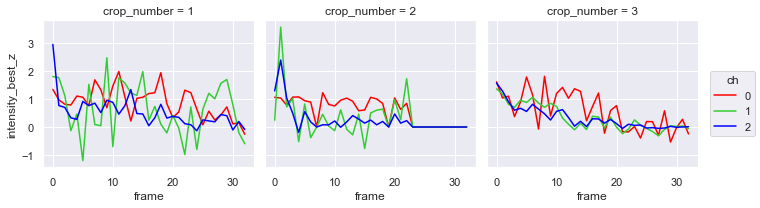

In [96]:
sns.set_palette(['red','limegreen','blue'])
g=my_signal_norm.sel(crop_number=slice(1,3)).plot(col='crop_number',hue='ch')


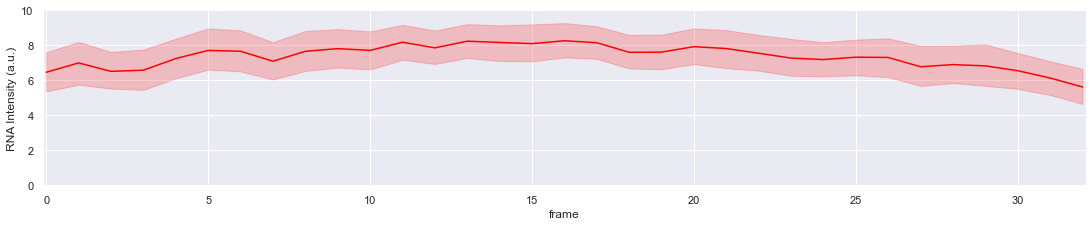

In [92]:
sns.set_style('darkgrid')
my_data = my_signal.sel(ch=0).to_pandas()
g=sns.relplot(x='frame', y='RNA Intensity (a.u.)',data=pd.melt(my_data,value_name="RNA Intensity (a.u.)"),kind='line',height=3,aspect=5)
g.set(ylim=(0, 10))
g.set(xlim=(-.1,32.1))
plt.savefig('test.svg', format = 'svg', dpi=300)

C:\Users\tim_s\Anaconda3\lib\site-packages\xarray\plot\plot.py:1344: FutureWarning: Conversion of the second argument of issubdtype from `str` to `str` is deprecated. In future, it will be treated as `np.str_ == np.dtype(str).type`.
  if np.issubdtype(x.dtype, str):
C:\Users\tim_s\Anaconda3\lib\site-packages\xarray\plot\plot.py:1395: FutureWarning: Conversion of the second argument of issubdtype from `str` to `str` is deprecated. In future, it will be treated as `np.str_ == np.dtype(str).type`.
  if np.issubdtype(v.dtype, str):


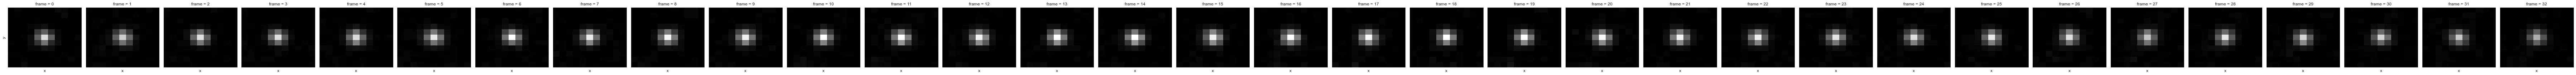

In [69]:
my_ds.intensity_best_z_bg.groupby('frame').mean('crop_number').sel(ch=0).plot.imshow(col='frame',yticks=[],xticks=[],cmap='gray',add_colorbar=False, vmin=0,vmax=50)

In [80]:
donut_sanity_check = my_ds.intensity_best_z_bg.where(lambda x: (x.x**2 + x.y**2 >= 5**2) & (x.x**2 + x.y**2 < 6**2)).mean(dim=['x','y'])

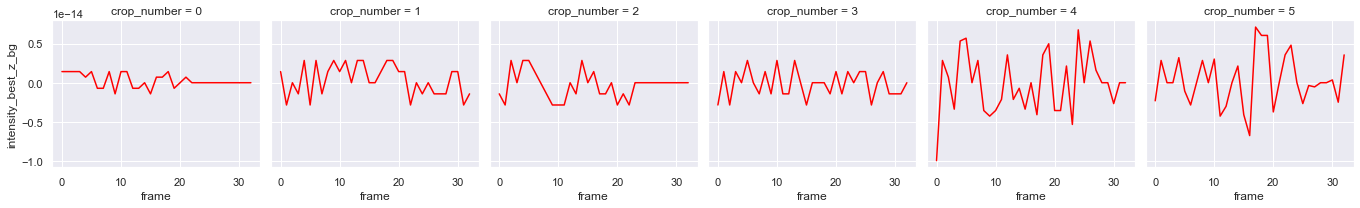

In [82]:
donut_sanity_check.sel(ch=0,crop_number=slice(0,5)).plot(col='crop_number',hue='ch',col_wrap=6)